# Libraries

In [ ]:
import pandas as pd
import tensorflow
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
import re
import sklearn
from sklearn.model_selection import train_test_split
import tqdm
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import make_pipeline
from tensorflow.keras import datasets,models,layers
from tensorflow.keras.layers import Conv1D, Concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D, Dense, Embedding, Input,BatchNormalization
from tensorflow.keras.models import Model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load data

In [ ]:

!kaggle datasets download -d kazanova/sentiment140

# Unzip the dataset
import zipfile
with zipfile.ZipFile('sentiment140.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Delete the zip file
import os
os.remove('sentiment140.zip')

# List files in the dataset directory
os.listdir('.')

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
100% 80.9M/80.9M [00:05<00:00, 20.3MB/s]
100% 80.9M/80.9M [00:05<00:00, 15.2MB/s]


['.config', 'training.1600000.processed.noemoticon.csv', 'sample_data']

In [ ]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = 'latin',header=None)

In [ ]:
data = data[[5, 0]]
data.columns=['tweet', 'sentiment']

In [ ]:
data['sentiment'] = data['sentiment'].replace(4,1)

<ipython-input-5-85226499ea73>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['sentiment'].replace(4,1)


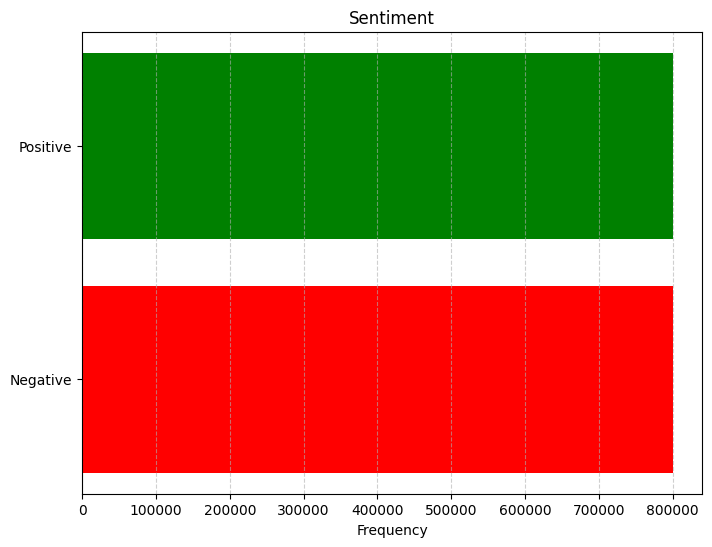

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Sans'
sentiment_counts = data['sentiment'].value_counts()
sentiment_labels = {'Negative': 0, 'Positive': 1}
plt.figure(figsize=(8, 6))
plt.barh(list(sentiment_labels.keys()), list(sentiment_counts.values), color=['red', 'green', 'blue'])
plt.xlabel("Frequency")
plt.yticks(list(sentiment_labels.values()), list(sentiment_labels.keys()))
plt.title("Sentiment")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

# Preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    # Removing URLS
    text = re.sub(r"https?://\S+|www\.\S+"," ",text)

    # Removing html tags
    text = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"," ",text)

    # Removing the Punctuation
    text = re.sub(r"[^\w\s]", " ", text)

    # Removing words that have numbers
    text = re.sub(r"\w*\d\w*", " ", text)

    # Removing Digits
    text = re.sub(r"[0-9]+", " ", text)

    # Cleaning white spaces
    text = re.sub(r"\s+", " ", text).strip()

    text = text.lower()
    # Check stop words
    tokens = []
    for token in text.split():
        if token not in stop_words and len(token) > 3:
            tokens.append(token)
    return " ".join(tokens)

In [ ]:
data.loc[:, 'tweet'] = data['tweet'].apply(preprocess)

# Split Data

In [ ]:
X = data['tweet']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print("Train Data size:", len(X_train), len(y_train))
print("Test Data size", len(X_test), len(y_test))

Train Data size: 1280000 1280000
Test Data size 320000 320000


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
max_length = max([len(seq) for seq in X_train])
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
print(f"After padding: {X_train.shape}")
print(f"After padding:{X_test.shape}")

After padding: (1280000, 27)
After padding:(320000, 27)


In [ ]:
batch_size=512
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 100

In [ ]:
CNN=models.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.Dropout(0.5),

    layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    layers.GlobalMaxPooling1D(),

    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

CNN.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [ ]:
history=CNN.fit(X_train, y_train, epochs=20,batch_size=batch_size)

Epoch 1/20
2500/2500 [==============================] - 95s 36ms/step - loss: 0.5046 - accuracy: 0.7520
Epoch 2/20
2500/2500 [==============================] - 52s 21ms/step - loss: 0.4146 - accuracy: 0.8132
Epoch 3/20
2500/2500 [==============================] - 51s 21ms/step - loss: 0.3476 - accuracy: 0.8455
Epoch 4/20
2500/2500 [==============================] - 51s 20ms/step - loss: 0.3099 - accuracy: 0.8612
Epoch 5/20
2500/2500 [==============================] - 50s 20ms/step - loss: 0.2885 - accuracy: 0.8710
Epoch 6/20
2500/2500 [==============================] - 50s 20ms/step - loss: 0.2728 - accuracy: 0.8785
Epoch 7/20
2500/2500 [==============================] - 49s 20ms/step - loss: 0.2600 - accuracy: 0.8839
Epoch 8/20
2500/2500 [==============================] - 50s 20ms/step - loss: 0.2489 - accuracy: 0.8896
Epoch 9/20
2500/2500 [==============================] - 50s 20ms/step - loss: 0.2394 - accuracy: 0.8934
Epoch 10/20
2500/2500 [==============================] - 49s 20m

In [ ]:
CNN.evaluate(X_test, y_test)

10000/10000 [==============================] - 23s 2ms/step - loss: 1.3522 - accuracy: 0.7336


[1.352174162864685, 0.7335749864578247]

In [ ]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 100)           45102700  
                                                                 
 dropout (Dropout)           (None, 27, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 25, 256)           77056     
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 256)           196864    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                        

10000/10000 [==============================] - 20s 2ms/step


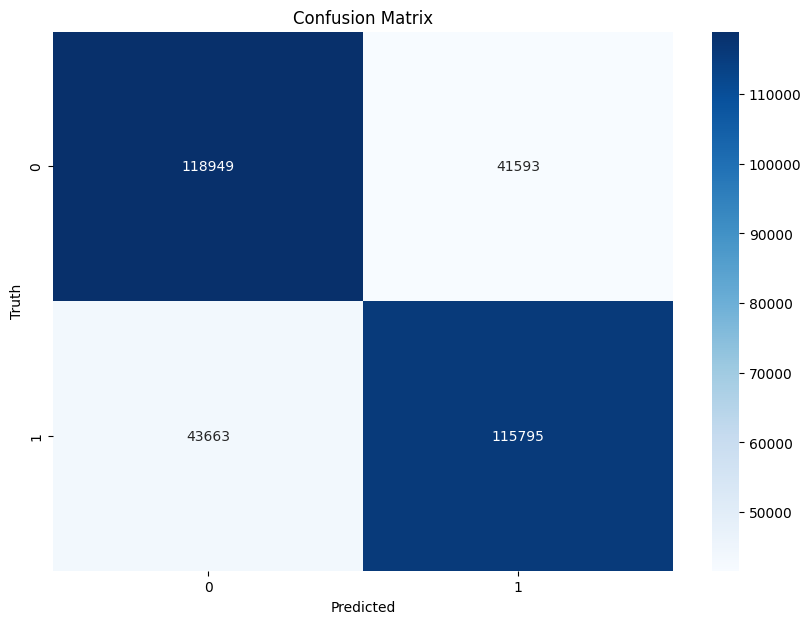

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
y_pred = CNN.predict(X_test)
y_pred_rounded = np.round(y_pred)
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_rounded)
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:

from sklearn.metrics import classification_report


# Print classification report
print(classification_report(y_test, y_pred_rounded, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.73      0.74      0.74    160542
    Positive       0.74      0.73      0.73    159458

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000



# VGG-16 architecture

In [ ]:
# from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense
# from tensorflow.keras.models import Model

# # Define the model
# embedding_layer = Embedding(vocab_size, 100, input_length=max_length, trainable=False)
# sequence_input = Input(shape=(max_length,), dtype='int32')
# embedding_sequences = embedding_layer(sequence_input)

# x = Conv1D(64, 3, activation='relu', padding='same')(embedding_sequences)
# x = Conv1D(64, 3, activation='relu', padding='same')(x)
# x= MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

# x = Conv1D(128, 3, activation='relu', padding='same')(x)
# x = Conv1D(128, 3, activation='relu', padding='same')(x)
# x = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

# x = Conv1D(256, 3, activation='relu', padding='same')(x)
# x = Conv1D(256, 3, activation='relu', padding='same')(x)
# x = Conv1D(256, 3, activation='relu', padding='same')(x)
# x = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

# x = Conv1D(512, 3, activation='relu', padding='same')(x)
# x = Conv1D(512, 3, activation='relu', padding='same')(x)
# x = Conv1D(512, 3, activation='relu', padding='same')(x)
# x = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

# x = Conv1D(512, 3, activation='relu', padding='same')(x)
# x = Conv1D(512, 3, activation='relu', padding='same')(x)
# x = Conv1D(512, 3, activation='relu', padding='same')(x)

# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# x = Dense(512, activation='relu')(x)

# outputs = Dense(1, activation='sigmoid')(x)

# model_vgg16 = Model(sequence_input, outputs)

# # Compile the model
# model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# history = model_vgg16.fit(X_train, y_train, batch_size=64, epochs=5)

In [ ]:
# loss, accuracy = model_vgg16.evaluate(X_test, y_test)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [ ]:
# model_vgg16.summary()

# Inception Architecture

In [ ]:
# # Define the model
# sequence_input = Input(shape=(max_length,), dtype='int32')
# embedding_sequences = embedding_layer(sequence_input)

# l1 = Conv1D(64, 1, activation='relu', padding='same')(embedding_sequences)
# l2 = Conv1D(64, 3, activation='relu', padding='same')(embedding_sequences)
# l3 = Conv1D(64, 5, activation='relu', padding='same')(embedding_sequences)
# l4 = Conv1D(64, 7, activation='relu', padding='same')(embedding_sequences)
# l5 = Conv1D(64, 9, activation='relu', padding='same')(embedding_sequences)
# l6 = MaxPooling1D(pool_size=3, strides=1, padding='same')(embedding_sequences)
# l6 = Conv1D(64, 1, activation='relu', padding='same')(l6)

# l = Concatenate(axis=-1)([l1, l2, l3, l4, l5, l6])
# l = Flatten()(l)
# l = Dense(512, activation='relu')(l)
# l = Dense(512, activation='relu')(l)

# outputs = Dense(1, activation='sigmoid')(l)

# model_inception = Model(sequence_input, outputs)

# # Compile the model
# model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# history = model_inception.fit(X_train, y_train, batch_size=64, epochs=5)

In [ ]:
# loss, accuracy = model_inception.evaluate(X_test, y_test)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [ ]:
# model_inception.summary()

In [ ]:
# y_pred = model_inception.predict(X_test)
# y_pred_rounded = np.round(y_pred)
# cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_rounded)
# plt.figure(figsize=(10, 7))
# sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

In [ ]:

from sklearn.metrics import classification_report


# Print classification report
print(classification_report(y_test, y_pred_rounded, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.73      0.74      0.74    160542
    Positive       0.74      0.73      0.73    159458

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000



In [ ]:
def predict_sentiments(model, tokenizer, data, num_samples=10):
    results = []
    for _ in range(num_samples):
        index = np.random.randint(0, len(data))
        tweet = data.iloc[index]['tweet']
        y_true = data.iloc[index]['sentiment']
        cleaned_tweet = preprocess(tweet)
        sequence = tokenizer.texts_to_sequences([cleaned_tweet])
        padded_sequence = pad_sequences(sequence, maxlen=max_length)
        prediction = model.predict(padded_sequence)[0][0]
        sentiment = "Positive" if prediction >= 0.5 else "Negative"
        results.append((tweet, sentiment, y_true))

    return results

results = predict_sentiments(CNN, tokenizer, data, num_samples=10)
for i, (tweet, sentiment, y_true) in enumerate(results, 1):
    print(f"Sample {i}:")
    print("Tweet:", tweet)
    print("Predicted Sentiment:", sentiment)
    print("True Sentiment:", "Positive" if y_true == 1 else "Negative")
    print()

1/1 [==============================] - 0s 26ms/step
Sample 1:
Tweet: asking everyone join know going thru phone
Predicted Sentiment: Positive
True Sentiment: Positive

Sample 2:
Tweet: thank
Predicted Sentiment: Positive
True Sentiment: Positive

Sample 3:
Tweet: damn
Predicted Sentiment: Negative
True Sentiment: Negative

Sample 4:
Tweet: katiesantry birthday days gemini geminis best
Predicted Sentiment: Positive
True Sentiment: Positive

Sample 5:
Tweet: blackberry troubles fortunately enough touch works fine almost years
Predicted Sentiment: Positive
True Sentiment: Positive

Sample 6:
Tweet: sweetlisi hope feel better sweetie congested fever related maybe sinus congestion pressure causes aches
Predicted Sentiment: Positive
True Sentiment: Negative

Sample 7:
Tweet: please visit justin site thanks good songs music icarly related
Predicted Sentiment: Positive
True Sentiment: Positive

Sample 8:
Tweet: feeling beautiful today
Predicted Sentiment: Negative
True Sentiment: Positive

Sam

In [ ]:
# Assuming preprocess, max_length, tokenizer, and CNN are defined and accessible

def predict_custom_input(model, tokenizer, input_text, max_length):
    cleaned_text = preprocess(input_text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)
    prediction = model.predict(padded_sequence)[0][0]
    sentiment = "Positive" if prediction >= 0.5 else "Negative"
    print("Predicted Sentiment:", sentiment)

# Example usage
custom_input = input("Enter a tweet: ")
predict_custom_input(CNN, tokenizer, custom_input, max_length)


Enter a tweet: hi
1/1 [==============================] - 0s 18ms/step
Predicted Sentiment: Negative


In [ ]:
import json
import numpy as np

# Save the history as a pickle file
import pickle

with open('history.bin', 'wb') as f:
    pickle.dump(history.history, f)

# Save the model weights
CNN.save_weights('model_weights.h5')

# Save the model architecture as JSON
model_json = CNN.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

# Save the tokenizer
with open('tokenizer.bin', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save the max_length
max_length_array = np.array([max_length])
with open('max_length.bin', 'wb') as f:
    f.write(max_length_array.tobytes())


In [ ]:
import json
import numpy as np
import pickle

from google.colab import drive
drive.mount('/content/drive')
# Save the history as a binary file
with open('/content/drive/MyDrive/history.bin', 'wb') as f:
    pickle.dump(history.history, f)

# Save the model weights
CNN.save_weights('/content/drive/MyDrive/model_weights.h5')

# Save the model architecture as JSON
model_json = CNN.to_json()
with open('/content/drive/MyDrive/model.json', 'w') as json_file:
    json_file.write(model_json)

# Save the tokenizer
with open('/content/drive/MyDrive/tokenizer.bin', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save the max_length
max_length_array = np.array([max_length])
with open('/content/drive/MyDrive/max_length.bin', 'wb') as f:
    f.write(max_length_array.tobytes())


Mounted at /content/drive


In [ ]:

# Save the history as a pickle file
import pickle

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Save the model weights
CNN.save('model.h5')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save the max_length
with open('max_length.pkl', 'wb') as f:
    pickle.dump(max_length, f)

# Requirements for running the model in Flask:
# - Python 3.6 or higher
# - TensorFlow 2.0 or higher
# - Keras 2.3 or higher
# - Flask 1.0 or higher
# - h5py 2.10 or higher
# - pickle 4.0 or higher

# Instructions for running the model in Flask:
# 1. Install the required packages.
# 2. Load the saved model, tokenizer, and max_length.
# 3. Create a Flask app.
# 4. Define a route that accepts a tweet as input and returns the predicted sentiment.
# 5. Run the Flask app.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
with open('history.pkl', 'rb') as f:
    history = pickle.load(f)
CNN.save('/content/drive/MyDrive/model.h5')
with open('/content/drive/MyDrive/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('/content/drive/MyDrive/max_length.pkl', 'wb') as f:
    pickle.dump(max_length, f)


KeyboardInterrupt: 

In [ ]:
import json
import joblib
import numpy as np

# Save the history as a pickle file
import pickle

with open('history.bin', 'wb') as f:
    pickle.dump(history.history, f)

# Save the model weights
CNN.save_weights('model_weights.h5')

# Save the model architecture as JSON
model_json = CNN.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

# Save the tokenizer
joblib.dump(tokenizer, 'tokenizer.joblib')

# Save the max_length
joblib.dump(max_length, 'max_length.joblib')


['max_length.joblib']

In [ ]:
import json
import numpy as np
import pickle
import joblib

from google.colab import drive
drive.mount('/content/drive')

# Save the history as a binary file
with open('/content/drive/MyDrive/history.bin', 'wb') as f:
    pickle.dump(history.history, f)

# Save the model weights
CNN.save_weights('/content/drive/MyDrive/model_weights.h5')

# Save the model architecture as JSON
model_json = CNN.to_json()
with open('/content/drive/MyDrive/model.json', 'w') as json_file:
    json_file.write(model_json)

# Save the tokenizer
joblib.dump(tokenizer, '/content/drive/MyDrive/tokenizer.joblib')

# Save the max_length
joblib.dump(max_length, '/content/drive/MyDrive/max_length.joblib')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/max_length.joblib']